In [ ]:
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import Precision, Recall
import tensorflow as tf

# 修改后的 UNet 模型，使用交叉熵损失
def unet_multiclass_crossentropy(input_size=(256, 256, 3), num_classes=4):
    inputs = Input(input_size)

    # 编码部分
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
    conv4 = BatchNormalization()(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool4)
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv5)
    conv5 = BatchNormalization()(conv5)
    drop5 = Dropout(0.5)(conv5)

    # 解码部分
    up6 = Conv2D(512, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2, 2))(drop5))
    merge6 = concatenate([drop4, up6], axis=3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv6)
    conv6 = BatchNormalization()(conv6)

    up7 = Conv2D(256, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2, 2))(conv6))
    merge7 = concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv7)
    conv7 = BatchNormalization()(conv7)

    up8 = Conv2D(128, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2, 2))(conv7))
    merge8 = concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge8)
    conv8 = BatchNormalization()(conv8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv8)
    conv8 = BatchNormalization()(conv8)

    up9 = Conv2D(64, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2, 2))(conv8))
    merge9 = concatenate([conv1, up9], axis=3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge9)
    conv9 = BatchNormalization()(conv9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
    conv9 = BatchNormalization()(conv9)

    # 修改输出层：通道数为 num_classes，激活函数为 softmax
    conv10 = Conv2D(num_classes, 1, activation='softmax')(conv9)

    model = Model(inputs=inputs, outputs=conv10)

    # 使用交叉熵损失和分类指标
    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy', Precision(), Recall()])
    return model


D:\arcgis pro\bin\Python\envs\arcgispro-py3\lib\site-packages\scipy\__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [ ]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping

# 配置路径
image_folder = "/kaggle/input/unet-dataset-2-15/image_shandong_roofandyard_version2/image_shandong_roofandyard_version2"  # 替换为你的image文件夹路径
label_folder = "/kaggle/input/unet-dataset-2-15/label_shandong_roofandyard-version2/label_shandong_roofandyard-version2"  # 替换为你的label文件夹路径
output_shape = (256, 256)  # 设置统一大小，例如256x256


# 加载图片
def load_images_from_folder(folder, resize_shape=None):
    filenames = sorted(os.listdir(folder))
    for filename in filenames:
        if filename.endswith('.TIF'):
            filepath = os.path.join(folder, filename)
            img = load_img(filepath, target_size=resize_shape)  # 使用 Keras 的 load_img
            img = img_to_array(img) / 255.0  # 转换为NumPy数组并归一化
            yield img, filename  # 按需生成图片和文件名

# 加载标签
def load_labels_from_folder(folder, resize_shape=None):
    filenames = sorted(os.listdir(folder))
    for filename in filenames:
        if filename.endswith('.TIF'):
            filepath = os.path.join(folder, filename)
            label = load_img(filepath, target_size=resize_shape, color_mode='grayscale')  # 加载为灰度图像
            label_array = img_to_array(label).squeeze(axis=-1)  # 转为NumPy数组，去掉多余维度
            label_array[label_array == 34] = 1
            label_array[label_array == 51] = 2
            label_array[label_array == 68] = 3
            label_array[label_array == 0] = 0
            yield label_array, filename  # 按需生成标签和文件名

# 数据增强函数
def augment_data(images, labels):
    augmented_images = []
    augmented_labels = []
    for img, lbl in zip(images, labels):
        augmented_images.append(img)
        augmented_labels.append(lbl)
        augmented_images.append(np.flip(img, axis=1))
        augmented_labels.append(np.flip(lbl, axis=1))
        augmented_images.append(np.flip(img, axis=0))
        augmented_labels.append(np.flip(lbl, axis=0))
    return augmented_images, augmented_labels

# 创建一个生成器，按批次加载数据
def data_generator(X, y, batch_size=2):
    # 无限循环生成器
    while True:
        for i in range(0, len(X), batch_size):
            X_batch = X[i:i + batch_size]
            y_batch = y[i:i + batch_size]
            yield np.array(X_batch), np.array(y_batch)

# 创建验证数据的生成器
def val_data_generator(X, y, batch_size=2):
    while True:
        for i in range(0, len(X), batch_size):
            yield X[i:i + batch_size], y[i:i + batch_size]

# 加载并处理数据
images, labels = [], []
for img, _ in load_images_from_folder(image_folder, resize_shape=output_shape):
    images.append(img)
for lbl, _ in load_labels_from_folder(label_folder, resize_shape=output_shape):
    labels.append(lbl)

images = np.array(images)
labels = np.array(labels)

# 转换标签为one-hot编码 (适配多分类问题)
num_classes = 4
labels_one_hot = to_categorical(labels, num_classes=num_classes)

# 划分数据集 (7:3)
X_train, X_val, y_train, y_val = train_test_split(images, labels_one_hot, test_size=0.3, random_state=42)

# 对训练集进行数据增强
X_train_aug, y_train_aug = augment_data(X_train, y_train)

# 设置模型
model = unet_multiclass_crossentropy(input_size=(256, 256, 3), num_classes=4)

# 设置模型检查点回调
checkpoint = ModelCheckpoint(
    'unet_model_roofandyard_2_15_final.keras',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)
early_stop = EarlyStopping(
    monitor='val_loss',    # 监控验证损失
    min_delta=0.001,       # 视为改进的最小变化量
    patience=4,            # 允许连续5个epoch不改进
    mode='min',            # 监控指标越小越好
    baseline=None,         # 可选设置基准值
    restore_best_weights=True  # 自动恢复最佳模型参数
)

# 设置批量大小
batch_size = 2

# 计算steps_per_epoch和validation_steps
steps_per_epoch = len(X_train_aug) // batch_size
validation_steps = len(X_val) // batch_size

# 训练模型
history = model.fit(
    data_generator(X_train_aug, y_train_aug, batch_size=batch_size),
    epochs=30,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_data_generator(X_val, y_val, batch_size=batch_size),
    validation_steps=validation_steps,
    callbacks=[checkpoint, early_stop]  # 添加早停回调
)
# 保存训练好的模型
model.save('/kaggle/working/unet_model_2_15_final.keras')

# 绘制loss和accuracy变化曲线
plt.figure(figsize=(12, 6))

# 绘制Loss曲线
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# 绘制Accuracy曲线
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [3]:
# 修改后的评估部分代码（替换原有评估代码）
print("Evaluating model on validation set...")
from sklearn.metrics import precision_score, recall_score, f1_score, jaccard_score
import numpy as np

# 获取预测结果
y_pred = model.predict(X_val, verbose=0)

# 转换预测结果和真实标签
y_pred_classes = np.argmax(y_pred, axis=-1)  # shape: (num_samples, H, W)
y_true_classes = np.argmax(y_val, axis=-1)  # shape: (num_samples, H, W)

# 展平数据
y_pred_flat = y_pred_classes.flatten()
y_true_flat = y_true_classes.flatten()

# 定义类别映射
CLASS_NAMES = ['Background', 'Courtyard', 'N-S-Roof','W-E-Roof']

# 计算每个类别的指标
precision = precision_score(y_true_flat, y_pred_flat, average=None, zero_division=0)
recall = recall_score(y_true_flat, y_pred_flat, average=None, zero_division=0)
f1 = f1_score(y_true_flat, y_pred_flat, average=None, zero_division=0)
iou = jaccard_score(y_true_flat, y_pred_flat, average=None, zero_division=0)

# 计算综合指标（排除背景）
roof_idx, courtyard_idx = 1, 2
macro_f1 = f1_score(y_true_flat, y_pred_flat, average='macro', zero_division=0)
mIoU = jaccard_score(y_true_flat, y_pred_flat, average='macro', zero_division=0)

# 打印详细结果
print("\n=== 类别级指标 ===")
for i, name in enumerate(CLASS_NAMES):
    print(f"{name}:")
    print(f"  Precision: {precision[i]:.4f}")
    print(f"  Recall:    {recall[i]:.4f}")
    print(f"  F1-Score:  {f1[i]:.4f}")
    print(f"  IoU:       {iou[i]:.4f}")

print("\n=== 重点关注指标 ===")
print(f"屋顶 IoU: {iou[roof_idx]:.4f} | F1: {f1[roof_idx]:.4f}")
print(f"庭院 IoU: {iou[courtyard_idx]:.4f} | F1: {f1[courtyard_idx]:.4f}")

print("\n=== 综合指标 ===")
print(f"宏平均 F1: {macro_f1:.4f} (包含背景)")
print(f"mIoU:       {mIoU:.4f} (包含背景)")



Evaluating model on validation set...

=== 类别级指标 ===
Background:
  Precision: 0.9499
  Recall:    0.9635
  F1-Score:  0.9566
  IoU:       0.9169
Courtyard:
  Precision: 0.9142
  Recall:    0.9059
  F1-Score:  0.9101
  IoU:       0.8350
N-S-Roof:
  Precision: 0.9244
  Recall:    0.9190
  F1-Score:  0.9217
  IoU:       0.8548
W-E-Roof:
  Precision: 0.9320
  Recall:    0.8082
  F1-Score:  0.8657
  IoU:       0.7632

=== 重点关注指标 ===
屋顶 IoU: 0.8350 | F1: 0.9101
庭院 IoU: 0.8548 | F1: 0.9217

=== 综合指标 ===
宏平均 F1: 0.9135 (包含背景)
mIoU:       0.8425 (包含背景)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 695ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━

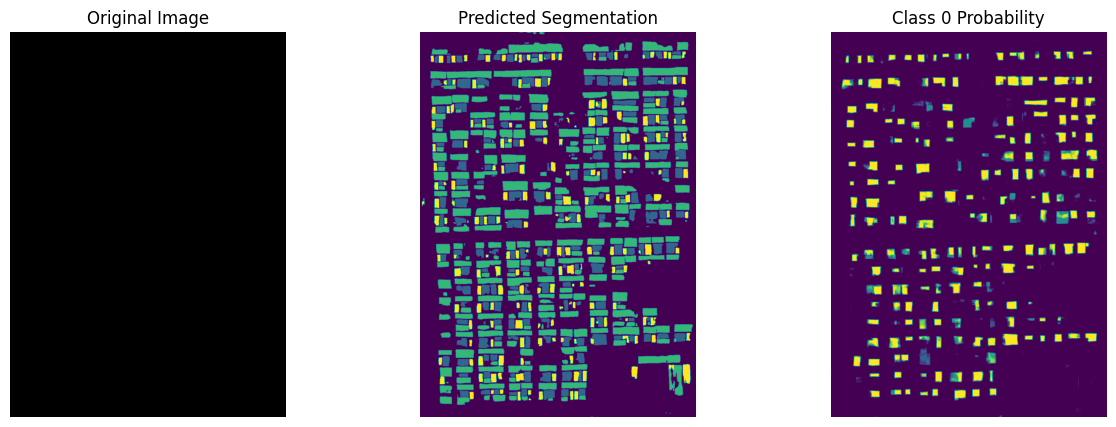

In [4]:
import matplotlib.pyplot as plt


def predict_single_image(image_path, output_folder, input_size=(256, 256), num_classes=4, patch_size=(256, 256), stride=(128, 128)):
    
      # 确保输出文件夹存在
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    # 加载图像
    img = load_img(image_path, target_size=None)  # 不调整大小
    img = img_to_array(img)
    original_shape = img.shape[:2]
    img = img / 255.0  # 归一化

    # 初始化预测结果数组
    prediction = np.zeros((original_shape[0], original_shape[1], num_classes))

    # 滑动窗口预测
    for y in range(0, original_shape[0] - patch_size[0], stride[0]):
        for x in range(0, original_shape[1] - patch_size[1], stride[1]):
            patch = img[y:y + patch_size[0], x:x + patch_size[1], :]
            # 调整大小以匹配模型输入
            patch = np.expand_dims(patch, axis=0)
            patch = tf.image.resize(patch, input_size)
            patch_pred = model.predict(patch)
            # 恢复到原始尺寸
            patch_pred = tf.image.resize(patch_pred, patch_size[:2])
            prediction[y:y + patch_size[0], x:x + patch_size[1], :] += patch_pred[0]

    # 处理剩余部分（边缘）
    y = original_shape[0] - patch_size[0]
    for x in range(0, original_shape[1] - patch_size[1], stride[1]):
        patch = img[y:y + patch_size[0], x:x + patch_size[1], :]
        patch = np.expand_dims(patch, axis=0)
        patch = tf.image.resize(patch, input_size)
        patch_pred = model.predict(patch)
        patch_pred = tf.image.resize(patch_pred, patch_size[:2])
        prediction[y:y + patch_size[0], x:x + patch_size[1], :] += patch_pred[0]

    x = original_shape[1] - patch_size[1]
    for y in range(0, original_shape[0] - patch_size[0], stride[0]):
        patch = img[y:y + patch_size[0], x:x + patch_size[1], :]
        patch = np.expand_dims(patch, axis=0)
        patch = tf.image.resize(patch, input_size)
        patch_pred = model.predict(patch)
        patch_pred = tf.image.resize(patch_pred, patch_size[:2])
        prediction[y:y + patch_size[0], x:x + patch_size[1], :] += patch_pred[0]

    # 处理右下角的剩余部分
    y = original_shape[0] - patch_size[0]
    x = original_shape[1] - patch_size[1]
    patch = img[y:y + patch_size[0], x:x + patch_size[1], :]
    patch = np.expand_dims(patch, axis=0)
    patch = tf.image.resize(patch, input_size)
    patch_pred = model.predict(patch)
    patch_pred = tf.image.resize(patch_pred, patch_size[:2])
    prediction[y:y + patch_size[0], x:x + patch_size[1], :] += patch_pred[0]

    # 取平均值作为最终预测结果
    prediction /= np.sum(prediction, axis=-1, keepdims=True)

    # 从原始图像路径中提取文件名
    filename = os.path.basename(image_path)
    # 将预测结果保存到文件
    output_path = os.path.join(output_folder, filename.replace('.TIF', '_prediction.TIF'))
    # 这里可以根据具体需求处理预测结果，例如将预测结果转换为所需的格式
    np.save(output_path, prediction)

    # 可视化预测结果
    plt.figure(figsize=(15, 5))
    # 显示原始图像
    plt.subplot(1, 3, 1)
    plt.imshow(img.astype(np.uint8))
    plt.title('Original Image')
    plt.axis('off')
    # 显示预测结果
    plt.subplot(1, 3, 2)
    predicted_class = np.argmax(prediction, axis=-1)
    plt.imshow(predicted_class)
    plt.title('Predicted Segmentation')
    plt.axis('off')
    # 显示预测结果的概率图（以第一类为例）
    plt.subplot(1, 3, 3)
    plt.imshow(prediction[:, :, 1], cmap='viridis')  # 这里以第一类的概率为例，可根据需求修改类别
    plt.title('Class 0 Probability')
    plt.axis('off')
    plt.show()


# 调用函数进行预测
image_path = '/kaggle/input/unet-dataset-2-15/shandong_weifang/shandong_weifang/shandong_weifang_yinmazhen_chongdexi.tif'  # 待预测图像的路径
output_folder = '/kaggle/working/'  # 预测结果输出文件夹路径
predict_single_image(image_path, output_folder)

In [6]:
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 67.6 MB/s eta 0:00:00:00:0100:01


预测完成


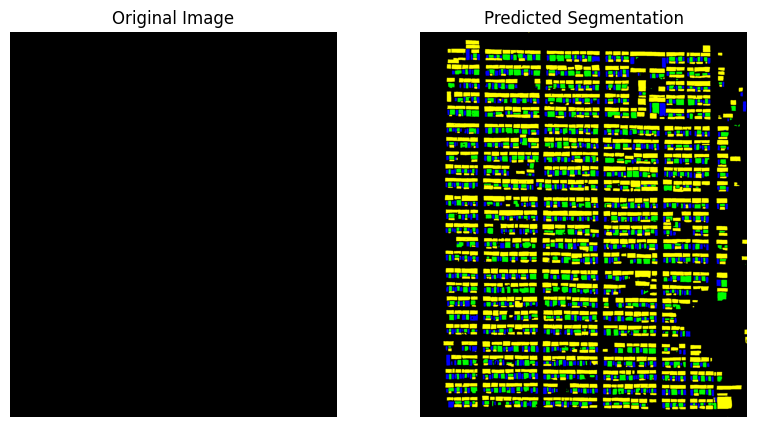

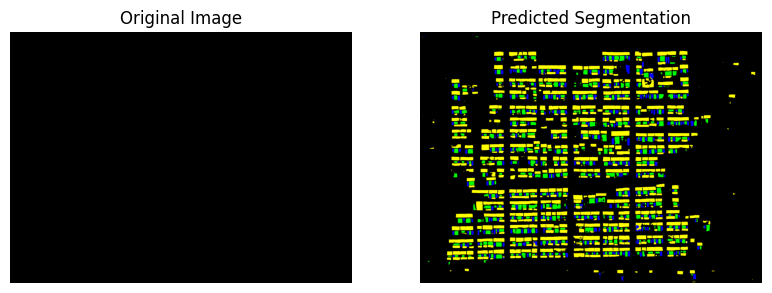

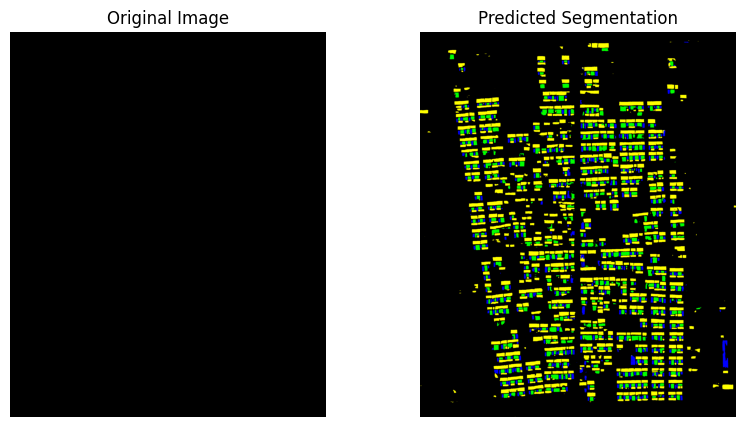

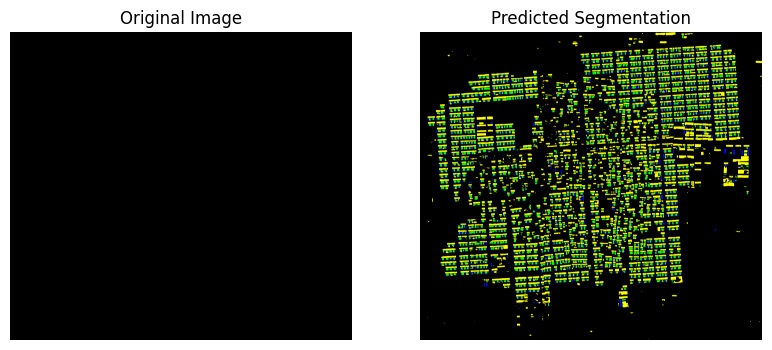

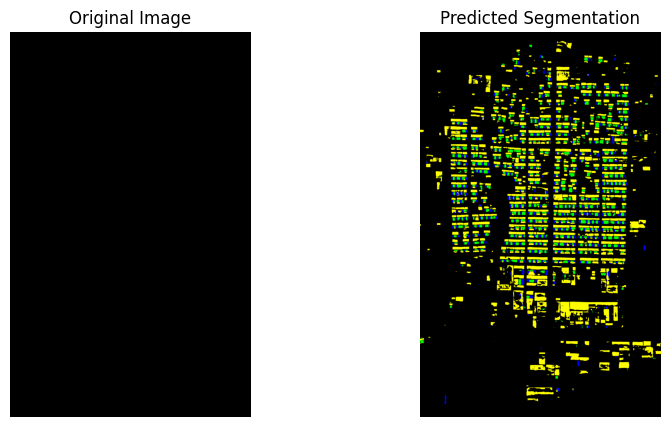

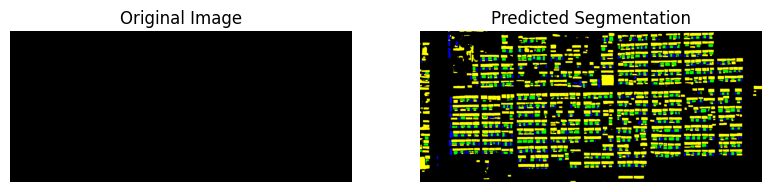

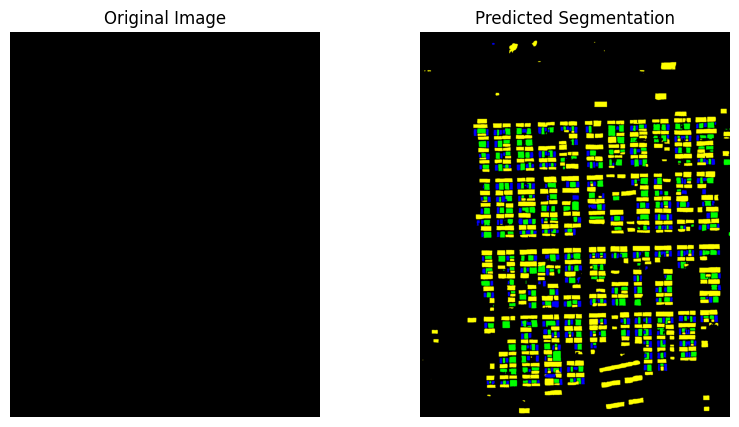

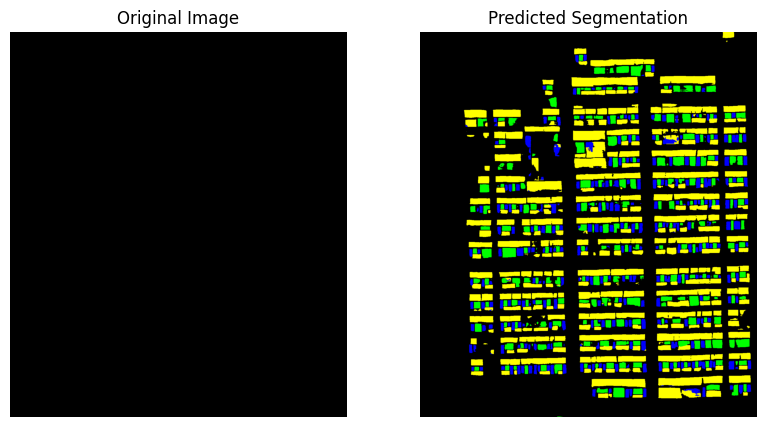

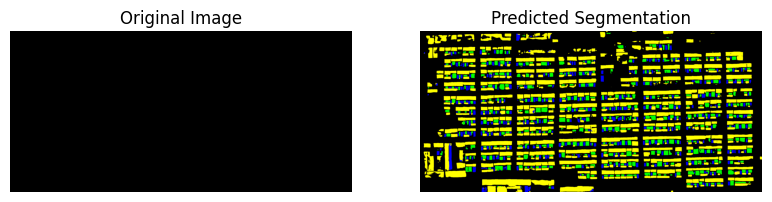

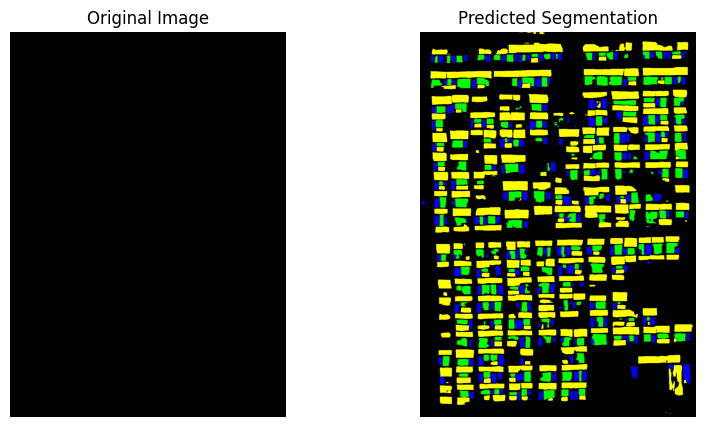

In [7]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from PIL import Image
import rasterio
from rasterio.transform import Affine


def predict_images_in_folder(image_folder, output_folder, input_size=(256, 256), num_classes=4, patch_size=(256, 256), stride=(128, 128)):
    # 加载训练好的模型
    # 确保输出文件夹存在
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    # 遍历图像文件夹中的所有图像文件
    for filename in os.listdir(image_folder):
        if filename.endswith('.TIF') or filename.endswith('.tif'):
            image_path = os.path.join(image_folder, filename)
            # 加载原始图像及地理信息
            with rasterio.open(image_path) as src:
                img = src.read()
                transform = src.transform
                crs = src.crs
                original_shape = img.shape[1:3]
                img = img.transpose(1, 2, 0) / 255.0  # 归一化并转换维度顺序

            # 初始化预测结果数组
            prediction = np.zeros((original_shape[0], original_shape[1], num_classes))

            # 滑动窗口预测
            for y in range(0, original_shape[0] - patch_size[0], stride[0]):
                for x in range(0, original_shape[1] - patch_size[1], stride[1]):
                    patch = img[y:y + patch_size[0], x:x + patch_size[1], :]
                    # 调整大小以匹配模型输入
                    patch = np.expand_dims(patch, axis=0)
                    patch = tf.image.resize(patch, input_size)
                    # 进行预测，设置 verbose 为 0 减少打印输出
                    patch_pred = model.predict(patch, verbose=0)
                    # 恢复到原始尺寸
                    patch_pred = tf.image.resize(patch_pred, patch_size[:2])
                    prediction[y:y + patch_size[0], x:x + patch_size[1], :] += patch_pred[0]

            # 处理剩余部分（边缘）
            y = original_shape[0] - patch_size[0]
            for x in range(0, original_shape[1] - patch_size[1], stride[1]):
                patch = img[y:y + patch_size[0], x:x + patch_size[1], :]
                patch = np.expand_dims(patch, axis=0)
                patch = tf.image.resize(patch, input_size)
                # 进行预测，设置 verbose 为 0 减少打印输出
                patch_pred = model.predict(patch, verbose=0)
                patch_pred = tf.image.resize(patch_pred, patch_size[:2])
                prediction[y:y + patch_size[0], x:x + patch_size[1], :] += patch_pred[0]

            x = original_shape[1] - patch_size[1]
            for y in range(0, original_shape[0] - patch_size[0], stride[0]):
                patch = img[y:y + patch_size[0], x:x + patch_size[1], :]
                patch = np.expand_dims(patch, axis=0)
                patch = tf.image.resize(patch, input_size)
                # 进行预测，设置 verbose 为 0 减少打印输出
                patch_pred = model.predict(patch, verbose=0)
                patch_pred = tf.image.resize(patch_pred, patch_size[:2])
                prediction[y:y + patch_size[0], x:x + patch_size[1], :] += patch_pred[0]

            # 处理右下角的剩余部分
            y = original_shape[0] - patch_size[0]
            x = original_shape[1] - patch_size[1]
            patch = img[y:y + patch_size[0], x:x + patch_size[1], :]
            patch = np.expand_dims(patch, axis=0)
            patch = tf.image.resize(patch, input_size)
            # 进行预测，设置 verbose 为 0 减少打印输出
            patch_pred = model.predict(patch, verbose=0)
            patch_pred = tf.image.resize(patch_pred, patch_size[:2])
            prediction[y:y + patch_size[0], x:x + patch_size[1], :] += patch_pred[0]

            # 取平均值作为最终预测结果
            prediction /= np.sum(prediction, axis=-1, keepdims=True)

            # 将预测结果保存为图像（tif 格式）
            output_path = os.path.join(output_folder, filename.replace('.TIF', '_prediction.TIF'))

            # 将预测结果转换为可视化图像
            predicted_class = np.argmax(prediction, axis=-1)
            color_map = np.zeros((original_shape[0], original_shape[1], 3), dtype=np.uint8)
            color_map[predicted_class == 0] = [0, 0, 0]  # 类别 1 用黑色表示
            color_map[predicted_class == 1] = [0, 255, 0]  # 类别 2 用绿色表示
            color_map[predicted_class == 2] = [255, 255, 0]  # 类别 3 用黄色表示
            color_map[predicted_class == 3] = [0, 0, 255] # 类别 3 用蓝色表示

            # 将预测结果保存为 GeoTIFF
            with rasterio.open(output_path, 'w', driver='GTiff', height=color_map.shape[0], width=color_map.shape[1],
                            count=3, dtype=color_map.dtype, crs=crs, transform=transform) as dst:
                dst.write(color_map.transpose(2, 0, 1))  # 转换维度顺序

            # 可视化预测结果
            plt.figure(figsize=(15, 5))
            # 显示原始图像
            plt.subplot(1, 3, 1)
            plt.imshow(img.astype(np.uint8))
            plt.title('Original Image')
            plt.axis('off')
            # 显示预测结果
            plt.subplot(1, 3, 2)
            plt.imshow(color_map)
            plt.title('Predicted Segmentation')
            plt.axis('off')
          

    print("预测完成")


# 调用函数进行预测

image_folder = '/kaggle/input/unet-dataset-2-15/shandong_weifang/shandong_weifang'  # 待预测图像的文件夹路径
output_folder = '/kaggle/working/shandong_predicted'  # 预测结果输出文件夹路径
predict_images_in_folder( image_folder, output_folder)
